# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [ ]:
# example of sparse metrics

from scipy import sparse

lst = [1, 2, 3, 4, 5, 6, 7]

ans = sparse.csr_matrix(lst)
print(ans)

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the data from the database
# using the SQLite Table to read data.
database = '/content/drive/My Drive/AFD/database.sqlite'

con = sqlite3.connect(database)

print(con)

# **Read the data**

In [ ]:
# filtering only positive as (1) and negative as (0) reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 
# for tsne assignment you can take 5k data points or less (for the sake of speed in real life problems its better to choose a bigger sample)
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x): 
  if x < 3:
      return 0
  return 1

#changing reviews with score more than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative 

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(15)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,1,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [ ]:
# group the the table by userId

display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1 LIMIT 50000
""", con)

print(display.shape) # notice the number we are quring 5k also
display.head(5)

(50000, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='#oc-R11D9D7SHXIJB9'] #showing a row by userId

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3


In [ ]:
display['COUNT(*)'].sum() 

242667

# **Exploratory Data Analysis**
## Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


### *note*
When we do data cleaning we have to experiment with the data and try to find by ourself if the data is duplicated or if it's garbage somehow a gut feeling <br> 

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries 
# like find duplicates using this (subset) because these feature are the same in the duplication
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False) #keep means keep only one reviw and remove the duplicates
final.shape

(46072, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

#note be careful not to lose too much data throw the cleaning

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
# here we say that keep only the HelpfulnessD which is equall or bigger than HelpfulnessN.
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [ ]:
print(type(final))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive(1) and negative(0) reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

<b>Observation:-</b> the data is imbalanced 

#Text Preproccesing



Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews that have some of these problem
# note we should apply the change on all the data point as we will see later on
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50) #to spreate between the sentences

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [ ]:
# remove urls from text refer tofor more info : https://stackoverflow.com/a/40823105/4084039
#in case we have some urls we gotta remove them using re module 
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
#here we remove all the html, jsx element and we get only the text out of it
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
# we do deconstruction for the words for ex.(you've -> you have, I'm -> I am...etc) 
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
#we apply it to this review text
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [ ]:
#refre to for more info: https://stackoverflow.com/a/18082370/4084039
# remove words with numbers (alpha-numeric) ex.(in = "ABCD abcd AB55 55CD  , out = "ABCD abcd")
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip() #strip method removes all the whitespaces
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [ ]:
# refer to for more info: https://stackoverflow.com/a/5843547/4084039
# remove spacial, punctuation and spaces from string ex.(in "Special $#! spaces    23", out "Specialspaces23")
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [ ]:
#for more info refer to https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# so we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

# notice that this is a customized stopwords list to get a ready one refer to the link above

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents(steps) in a for loop then append it to the preprocessed_reviews 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values): 
    sentance = re.sub(r"http\S+", "", sentance) # remove the urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text() #remove html,jsx
    sentance = decontracted(sentance) # deconstractions you've -> you have
    sentance = re.sub("\S*\d\S*", "", sentance).strip() # remove the alpha-numeric words
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # removeing punctuation and spaces..etc
    # https://gist.github.com/sebleier/554280
    #this one to make all the letters lower case(notice that the we exclude the stopwords cuz they're already lower cased)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords) #make the e lower then we iterate over the sentance veriable
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:14<00:00, 3283.14it/s]


In [ ]:
#we check the preprocessed data
preprocessed_reviews[100]

'frenchbull given nylabone chew since weeks old safe strong bite not break large pieces could choke dinosaur chew perfect many places hold bite dylabone product buy'

In [ ]:
# we can do the same step for the summary data

# we apply it to the 'summary' feature

preprocessed_summary = []

for sentance1 in tqdm(final['Summary'].values): 
    sentance1 = re.sub(r"http\S+", "", sentance1) 
    sentance1 = BeautifulSoup(sentance1, 'lxml').get_text() 
    sentance1 = decontracted(sentance1) 
    sentance1 = re.sub("\S*\d\S*", "", sentance1).strip() 
    sentance1 = re.sub('[^A-Za-z]+', ' ', sentance1) 
    
    
    sentance1 = ' '.join(e.lower() for e in sentance1.split() if e.lower() not in stopwords) 
    preprocessed_summary.append(sentance1.strip())

100%|██████████| 87773/87773 [00:18<00:00, 4795.15it/s]


In [ ]:
preprocessed_summary[1500]

'hot stuff'

In [ ]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

### Data pipline

In [ ]:
X = np.array(preprocessed_reviews)
YY = final['Score']
Y = np.array(YY)

print(type(X))
print("="*50)
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(20680,) (20680,)
(10187,) (10187,)
(15204,) (15204,)


In [ ]:
# BOW
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)


After vectorizations
(20680, 27019) (20680,)
(10187, 27019) (10187,)
(15204, 27019) (15204,)


#Fixing The imbalanced data (Under & Over sampling methods)

## 1. Under Sampling

In [ ]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()

X_train_bow1, y_train1 = nm.fit_sample(X_train_bow, y_train)
X_cv_bow1, y_cv1  = nm.fit_sample(X_cv_bow, y_cv)
X_test_bow1, y_test1 = nm.fit_sample(X_test_bow, y_test)

In [ ]:
print("After under sampling")
print(X_train_bow1.shape, y_train1.shape)
print(X_cv_bow1.shape, y_cv1.shape)
print(X_test_bow1.shape, y_test1.shape)
print("="*100)

After under sampling
(6816, 27019) (6816,)
(3388, 27019) (3388,)
(4980, 27019) (4980,)


In [ ]:
import collections
a = collections.Counter(y_train)
print('before under sampling',a)
print("="*100)
b = collections.Counter(y_train1)
print('after under sampling',b)

before under sampling Counter({1: 17272, 0: 3408})
after under sampling Counter({0: 3408, 1: 3408})


## 2. Over Sampling

In [ ]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek()

X_train_bow2, y_train2 = smk.fit_sample(X_train_bow, y_train)
X_cv_bow2, y_cv2  = smk.fit_sample(X_cv_bow, y_cv)
X_test_bow2, y_test2 = smk.fit_sample(X_test_bow, y_test)

In [ ]:
print("After under sampling")
print(X_train_bow2.shape, y_train2.shape)
print(X_cv_bow2.shape, y_cv2.shape)
print(X_test_bow2.shape, y_test2.shape)
print("="*100)

After under sampling
(34542, 27019) (34542,)
(16986, 27019) (16986,)
(25424, 27019) (25424,)


In [ ]:
a1 = collections.Counter(y_train)
print('before under sampling',a1)
print("="*100)
b1 = collections.Counter(y_train2)
print('after under sampling',b1)

before under sampling Counter({1: 17272, 0: 3408})
after under sampling Counter({0: 17271, 1: 17271})


#Applying KNN

##BOW KNN

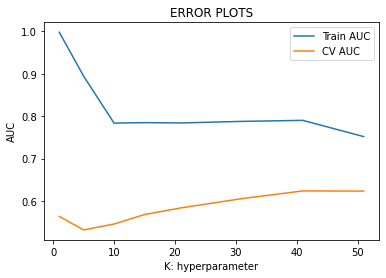

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K = [1, 5, 10, 15, 21, 31, 41, 51]
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_bow2, y_train2)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  neigh.predict_proba(X_train_bow2)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow2)[:,1]
    
    train_auc.append(roc_auc_score(y_train2,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv2, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=10, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_bow1, y_train1)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

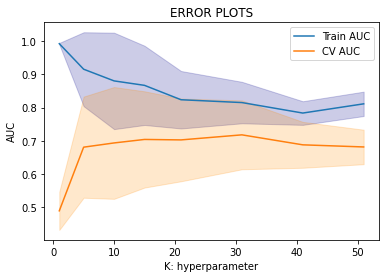

In [ ]:
K = [1, 5, 10, 15, 21, 31, 41, 51]
plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

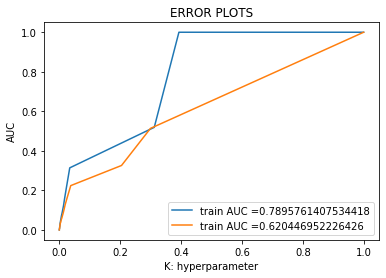

Train confusion matrix
[[17252    19]
 [17063   208]]
Test confusion matrix
[[12696    16]
 [12565   147]]


In [ ]:
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=40)
neigh.fit(X_train_bow2, y_train2)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train2, neigh.predict_proba(X_train_bow2)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test2, neigh.predict_proba(X_test_bow2)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train2, neigh.predict(X_train_bow2)))
print("Test confusion matrix")
print(confusion_matrix(y_test2, neigh.predict(X_test_bow2)))

#Applying Naive Beyes

##BOW Naive Bayes 

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)


After vectorizations
(4292, 12399) (4292,)
(2115, 12399) (2115,)
(3157, 12399) (3157,)


{'alpha': 1.0001}


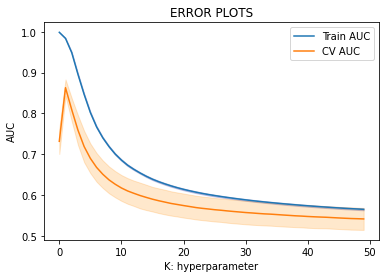

In [ ]:
# Hyper parameter using Gridsearch
from sklearn.model_selection import GridSearchCV

A = np.arange(0.0001,50)

NB = MultinomialNB()
parameters = {'alpha':np.arange(0.0001,50) }
clf = GridSearchCV(NB, parameters, cv=10, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_bow, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(clf.best_params_)


plt.plot(A, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(A,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(A, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(A,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

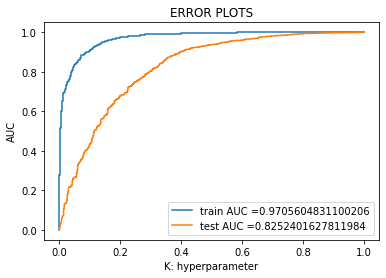

Train confusion matrix
[[ 464  293]
 [  23 3512]]
Test confusion matrix
[[ 116  381]
 [  30 2630]]


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


Clf= MultinomialNB(alpha=1.5)
Clf.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, Clf.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, Clf.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, Clf.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, Clf.predict(X_test_bow)))

##TF-IDFNaive Bayes 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=7)
tf_idf_vect.fit(X_train)

X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)


print("After vectorizations(TF_IDF)")
print(X_train_tf_idf.shape, y_train.shape)
print(X_cv_tf_idf.shape, y_cv.shape)
print(X_test_tf_idf.shape, y_test.shape)

After vectorizations(TF_IDF)
(4292, 4021) (4292,)
(2115, 4021) (2115,)
(3157, 4021) (3157,)


{'alpha': 1.0001}


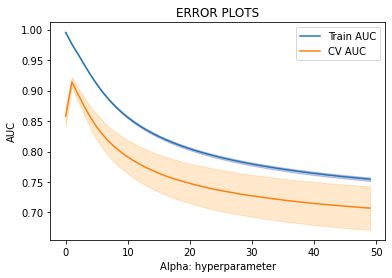

In [ ]:
# using gridsearch method hyper tunning

from sklearn.model_selection import GridSearchCV

A = np.arange(0.001,50)

NB = MultinomialNB()
parameters = {'alpha':np.arange(0.0001,50) }
clf = GridSearchCV(NB, parameters, cv=10, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_tf_idf, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

print(clf.best_params_)


plt.plot(A, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(A,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(A, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(A,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

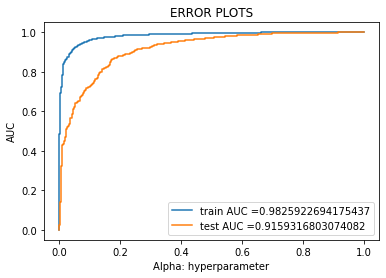

Train confusion matrix
[[ 318  439]
 [  11 3524]]
Test confusion matrix
[[  88  409]
 [   9 2651]]


In [ ]:
# testing Tf-idf

from sklearn.metrics import roc_curve, auc


Clf= MultinomialNB(alpha=0.5)
Clf.fit(X_train_tf_idf, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, Clf.predict_proba(X_train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, Clf.predict_proba(X_test_tf_idf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, Clf.predict(X_train_tf_idf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, Clf.predict(X_test_tf_idf)))

#Featurization

##1-BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
# here we are seeing some features notice the diffrent here and the function in Tf-idf way
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])#the first row and the first 10 features
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews) #Learn the vocabulary dictionary and return document-term matrix.
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## 2-Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram 

# removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2)) means we take only uni-gram & bi-gram
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000 of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) #max_features(means the number of feauters u are putting in )

final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## 3-TF-IDF

In [ ]:
# tf-idf
# here we use TfidfVectorizer() from scikit-learn to compute the tf-idf 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)#in scikit-learn
tf_idf_vect.fit(preprocessed_reviews)
# here we are seeing some features notice the diffrent here and the function in BoW way
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10]) #the first row and the first 10 features
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## 4-Word2vec

In [ ]:
# Using Google News Word2Vectors
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-09-26 18:20:14--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.26.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.26.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.2MB/s    in 46s     

2020-09-26 18:21:00 (34.4 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
#loading the pre-trained model
from gensim.models import KeyedVectors

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [ ]:
word2vec.wv.similarity('man', 'woman')

0.76640123

In [ ]:
word2vec.wv.most_similar('tasty')

[('delicious', 0.8730389475822449),
 ('scrumptious', 0.8007042407989502),
 ('yummy', 0.7856924533843994),
 ('flavorful', 0.7420164346694946),
 ('delectable', 0.7385421991348267),
 ('juicy_flavorful', 0.7114803791046143),
 ('appetizing', 0.7017217874526978),
 ('crunchy_salty', 0.7012300491333008),
 ('flavourful', 0.6912213563919067),
 ('flavoursome', 0.6857702732086182)]

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
print(preprocessed_reviews)

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors', 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs', 'glad cocker standard poodle puppy loves stuff trust brand superior nutrition compare labels previous feed pedigree mostly corn little dude healthy happy high energy glossy coat also superior nutrition produces smaller compact stools', 'using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever 

In [ ]:
# we split each sentance to a sprreate array
print(list_of_sentance)

[['product', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'genocide', 'pretty', 'stinky', 'right', 'nearby'], ['used', 'victor', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product'], ['received', 'shipment', 'could', 'hardly', 'wait', 'try', 'product', 'love', 'slickers', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'use', 'car', 'windows', 'printed', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'product', 'windows', 'everywhere', 'surfaces', 'like', 'tv', 'screens', 'computer', 'monitors'], ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decals', 'car', 'window', 'everybody', 'asks', 'bought', 'decals', 'made', 'two', 'thumbs'], ['glad', 'cocker', 'standard', 'poodle', 'puppy', 'loves', 'stuff', 'trust', 'brand', 'superior', 'nutrition', 'compare', 'labels', 'previous', 'feed', 'pedigree', 'mostly', 'corn', 'little', 'dude', 'healthy', 'happy', 

In [ ]:
#converting the words into vectors 

# min_count = 5 considers only words that occured atleast 5 times
# size 50 means convert the words into 50D vector(here we  are useing the size of 300d cuz we are using google model)
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=300, workers=4)

In [ ]:
# getting the dictionary of all the words that I have
w2v_words = list(word2vec.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

In [ ]:
# here im using my own trained on my data model
w2v_model.wv.most_similar('good')

[('really', 0.9993793368339539),
 ('rich', 0.9989293813705444),
 ('smooth', 0.9988985657691956),
 ('nice', 0.9988925457000732),
 ('bitter', 0.9988491535186768),
 ('spicy', 0.9987365007400513),
 ('enjoy', 0.9986323118209839),
 ('burnt', 0.998565673828125),
 ('not', 0.9985172748565674),
 ('overpowering', 0.9984995722770691)]

## 5- Converting text into vectors using Avg W2V, TFIDF-W2V
### We use these techniques converting sentances to vectors

## Avg W2V

In [ ]:
# average Word2Vec 
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words: # make sure that we adding only the words in our carpus
            vec = w2v_model.wv[word]# changing the words to 50D vectors(300D in this case)
            sent_vec += vec # store them in sent_vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words # we divide them to get the mean(avrage)
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:05<00:00, 958.24it/s] 

4986
300


In [ ]:
sent_vectors[1]

array([ 0.11595176, -0.12854252,  0.09767829,  0.19824026, -0.21876982,
       -0.14372994, -0.20204628,  0.06128153, -0.2022444 ,  0.03562616,
        0.10857189,  0.0253444 , -0.20547352, -0.06210342, -0.10394219,
        0.03938087, -0.08643865,  0.04301701,  0.14011219,  0.27247227,
       -0.01359657, -0.03729641,  0.03650269,  0.0465723 ,  0.12676971,
       -0.05223293, -0.05363725,  0.3860037 , -0.13601516,  0.07849932,
       -0.11099803,  0.05005313, -0.20296256,  0.0595775 ,  0.02145201,
       -0.2256191 ,  0.22906145, -0.01120935,  0.03204859,  0.12711538,
       -0.08494601,  0.07065039,  0.0226591 , -0.14513425, -0.04283027,
       -0.01702939,  0.03820519, -0.40818501,  0.03060558,  0.17457515,
       -0.07405419,  0.12220531,  0.22500225, -0.13234522,  0.36787034,
       -0.23774386, -0.29834435,  0.31441677,  0.03655124, -0.00250143,
        0.03391146, -0.17173288,  0.01608054, -0.2296481 ,  0.04240681,
       -0.17901837, -0.10437507, -0.03667493, -0.0607431 , -0.04

## TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are using 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent)) # getting the tf-idf values
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:33<00:00, 150.23it/s]


In [ ]:
tfidf_sent_vectors[1]

array([ 1.01383038e-01, -1.15048601e-01,  8.60293626e-02,  1.73347125e-01,
       -1.95144904e-01, -1.29402660e-01, -1.78228950e-01,  5.23948428e-02,
       -1.79231548e-01,  3.54515235e-02,  9.65485232e-02,  2.16329689e-02,
       -1.81036429e-01, -5.62693735e-02, -9.30609071e-02,  3.54450952e-02,
       -7.78691088e-02,  3.84929291e-02,  1.25861596e-01,  2.40351573e-01,
       -1.10619728e-02, -3.44240473e-02,  3.22366587e-02,  4.28038053e-02,
        1.11733224e-01, -4.70813992e-02, -4.90375525e-02,  3.41344921e-01,
       -1.21714599e-01,  7.01168278e-02, -9.72669905e-02,  4.51734502e-02,
       -1.81495147e-01,  5.43567452e-02,  1.94500748e-02, -2.03515159e-01,
        2.03158980e-01, -1.17374881e-02,  2.89639486e-02,  1.14025421e-01,
       -7.43303509e-02,  6.32889813e-02,  1.76475529e-02, -1.29519844e-01,
       -3.95272375e-02, -1.39167647e-02,  3.39968127e-02, -3.62638769e-01,
        2.83965141e-02,  1.53307104e-01, -6.73305855e-02,  1.08558749e-01,
        1.98777020e-01, -

# Plotting T-SNE

##BoW T-SNE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


input0 = final_counts
label = final['Score']


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=5000)

input0_embedding = tsne.fit_transform(input0.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix



In [ ]:
from sklearn.preprocessing import StandardScaler 
standardized_data = StandardScaler().fit_transform(input0_embedding) #take the data as an input and standerized to an output(standardized_data)
print(standardized_data.shape)

(4986, 2)


In [ ]:
print(type(standardized_data))
print(standardized_data.shape)
print(label.shape)

<class 'numpy.ndarray'>
(4986, 2)
(4986,)


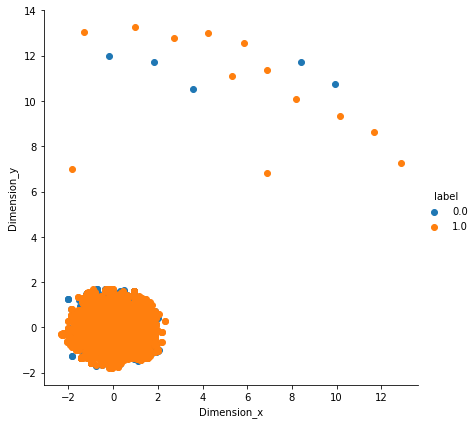

In [ ]:
for_tsne = np.vstack((standardized_data.T, label)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','label'])
sn.FacetGrid(for_tsne_df, hue="label", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.show()

## Bi-Grams and n-Grams T-SNE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as scipy

dense_in = scipy.sparse.csr_matrix.todense(final_bigram_counts)

from sklearn.preprocessing import StandardScaler 
standardized_data1 = StandardScaler().fit_transform(dense_in) #take the data as an input and standerized to an output(standardized_data)


input1 = standardized_data1
label1 = final['Score']


tsne = TSNE(n_components=2, perplexity=10,n_iter=5000)

input0_embedding = tsne.fit_transform(input1)

In [ ]:
print(type(input0_embedding))
print(input0_embedding.shape)
print(label1.shape)

<class 'numpy.ndarray'>
(4986, 2)
(4986,)


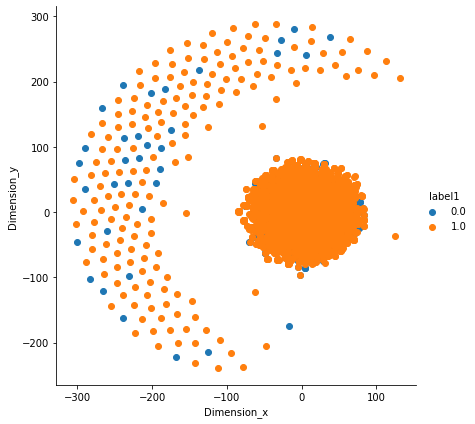

In [ ]:
for_tsne = np.vstack((input0_embedding.T, label1)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','label1'])
sn.FacetGrid(for_tsne_df, hue="label1", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.show()

##Word2Vec T-SNEE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as scipy

dense_in = tfidf_sent_vectors

from sklearn.preprocessing import StandardScaler 
standardized_data1 = StandardScaler().fit_transform(dense_in) #take the data as an input and standerized to an output(standardized_data)


input1 = standardized_data1
label1 = final['Score']


tsne = TSNE(n_components=2, perplexity=30,n_iter=3000)

input0_embedding = tsne.fit_transform(input1)

In [ ]:
print(type(input0_embedding))
print(input0_embedding.shape)
print(label1.shape)

<class 'numpy.ndarray'>
(4986, 2)
(4986,)


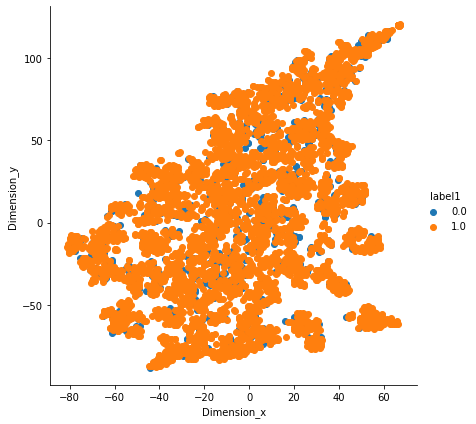

In [ ]:
for_tsne = np.vstack((input0_embedding.T, label1)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','label1'])
sn.FacetGrid(for_tsne_df, hue="label1", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.show()